In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


import numpy as np
import torch
from torch import nn
from tqdm.auto import tqdm
from glob import glob
import matplotlib.pyplot as plt
import lib.utils as utils
import lib.crps as crps

from run_wcrps_ens import Ensemble

In [2]:
datasets_order = {
    'bostonHousing': 'boston',
    'concrete': 'concrete',
    'energy': 'energy',
    'kin8nm': 'kin8nm',
    'naval-propulsion-plant': 'naval',
    'power-plant': 'power',
    'protein-tertiary-structure': 'protein',
    'wine-quality-red': 'wine',
    'yacht': 'yacht',
}

  0%|          | 0/9 [00:00<?, ?it/s]

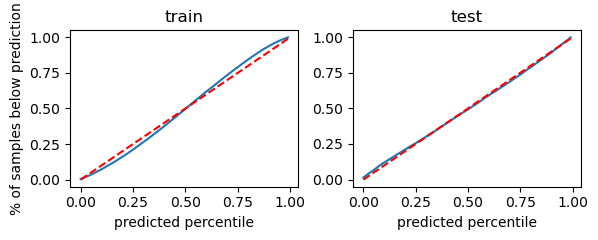

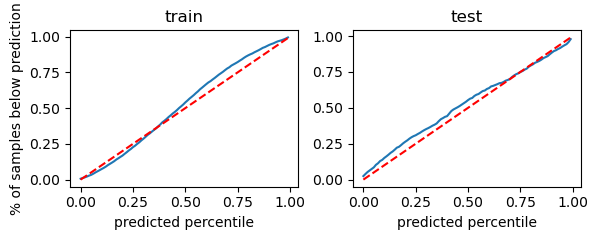

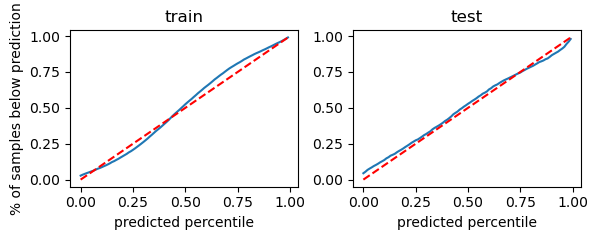

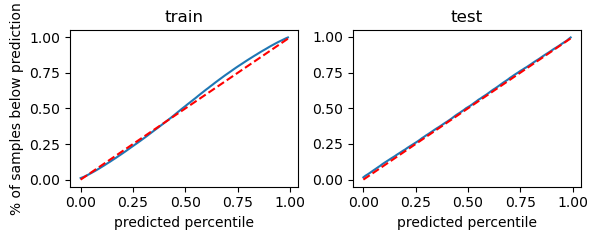

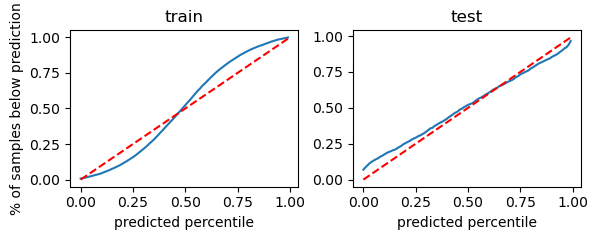

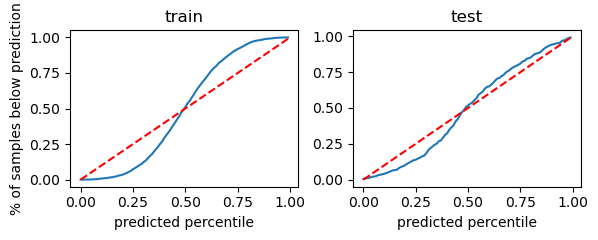

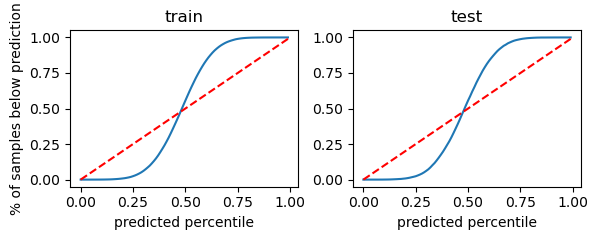

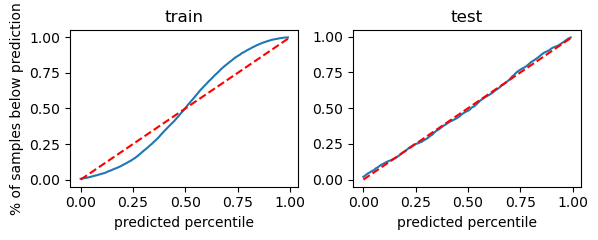

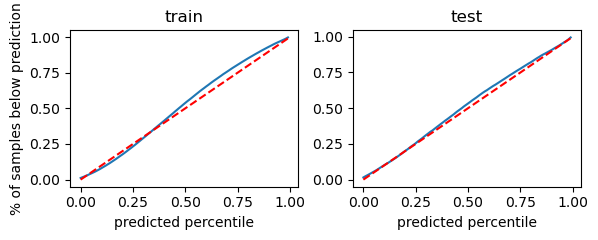

In [3]:
device="cuda:0"
default_params = {
    'splits': 20,
}

dataset_param_overrides = {
    'protein-tertiary-structure': {
        'splits': 5,
    },
}

data_repo_dir = "./DropoutUncertaintyExps/UCI_Datasets"
dataset_names = [dir.split("/")[-1] for dir in glob(data_repo_dir+"/*")]

calibs_train = []
calibs_test = []
for dataset_name in tqdm(dataset_names):
    params = dict(default_params, **dataset_param_overrides.get(dataset_name, {}))
    data_dir = data_repo_dir + "/%s/data/"%dataset_name
    data_path = data_dir + "data.txt"

    np.random.seed(1)
    data = np.loadtxt(data_path)

    def _get_index_train_test_path(split_num, train = True):
        if train:
            return data_dir + "index_train_" + str(split_num) + ".txt"
        else:
            return data_dir + "index_test_" + str(split_num) + ".txt" 

    splits = []
    for split in range(params['splits']):
        index_train = np.loadtxt(_get_index_train_test_path(split, train=True))
        index_test = np.loadtxt(_get_index_train_test_path(split, train=False))
        splits.append((index_train, index_test))

    ix_features = np.loadtxt(data_dir + "index_features.txt")
    ix_target = np.loadtxt(data_dir + "index_target.txt")

    X = data[ : , [int(i) for i in ix_features.tolist()] ]
    y = data[ : , int(ix_target.tolist()) ]


    calib_train=[]
    calib_test=[]
    for split_ix, (index_train, index_test) in enumerate(splits):
        X_train = X[ [int(i) for i in index_train.tolist()] ]
        y_train = y[ [int(i) for i in index_train.tolist()] ]
        X_test = X[ [int(i) for i in index_test.tolist()] ]
        y_test = y[ [int(i) for i in index_test.tolist()] ]

        X_train_original = X_train
        y_train_original = y_train
        num_training_examples = int(0.8 * X_train.shape[0])
        X_validation = X_train[num_training_examples:, :]
        y_validation = y_train[num_training_examples:]
        X_train = X_train[0:num_training_examples, :]
        y_train = y_train[0:num_training_examples]
            
        net = Ensemble(5, X_train.shape[1], 1).to(device)
        net.load_state_dict(torch.load("results/wcrps_ens/%s_%d.pt"%(dataset_name, split_ix), map_location=device))
        
        X_train_s, y_train_s, scalers = crps.prepare_training(net, X_train, y_train)
    
        train_pred_samples, train_pred_weights = crps.predict(net, scalers, X_train, n_samples=1000//5, batch_size=128)
        sort_ix = np.argsort(train_pred_samples, axis=1)
        sorted_samples = np.take_along_axis(train_pred_samples, sort_ix, axis=1)
        sorted_weights = np.take_along_axis(train_pred_weights, sort_ix, axis=1)
        sorted_weights_cs = np.cumsum(sorted_weights, axis=1)
        percentile_indices = (sorted_weights_cs[:, :, None] >= np.arange(9,1000,10)[None, None, :]).argmax(axis=1)
        percentiles_approx = np.take_along_axis(sorted_samples, percentile_indices, axis=1)
        calib_train.append((percentiles_approx > y_train.reshape(-1,1)).mean(axis=0))
    
        test_pred_samples, test_pred_weights = crps.predict(net, scalers, X_test, n_samples=1000//5, batch_size=128)
        sort_ix = np.argsort(test_pred_samples, axis=1)
        sorted_samples = np.take_along_axis(test_pred_samples, sort_ix, axis=1)
        sorted_weights = np.take_along_axis(test_pred_weights, sort_ix, axis=1)
        sorted_weights_cs = np.cumsum(sorted_weights, axis=1)
        percentile_indices = (sorted_weights_cs[:, :, None] >= np.arange(9,1000,10)[None, None, :]).argmax(axis=1)
        percentiles_approx = np.take_along_axis(sorted_samples, percentile_indices, axis=1)
        calib_test.append((percentiles_approx > y_test.reshape(-1,1)).mean(axis=0))

    plt.figure(figsize=(6,2.5))
    plt.subplot(1,2,1)
    calib = np.vstack(calib_train).mean(axis=0)
    plt.plot(np.arange(100)/100, calib)
    plt.plot(np.arange(100)/100, np.arange(100)/100, 'r--')
    plt.title("train")
    plt.ylabel('% of samples below prediction')
    plt.xlabel('predicted percentile')
    plt.subplot(1,2,2)
    calib = np.vstack(calib_test).mean(axis=0)
    plt.plot(np.arange(100)/100, calib)
    plt.plot(np.arange(100)/100, np.arange(100)/100, 'r--')
    plt.title("test")
    plt.xlabel('predicted percentile')

    plt.tight_layout()
    plt.savefig("plots/calibration_%s.pdf"%dataset_name)
    plt.show()
    calibs_train.append((dataset_name, np.vstack(calib_train).mean(axis=0)))
    calibs_test.append((dataset_name, np.vstack(calib_test).mean(axis=0)))

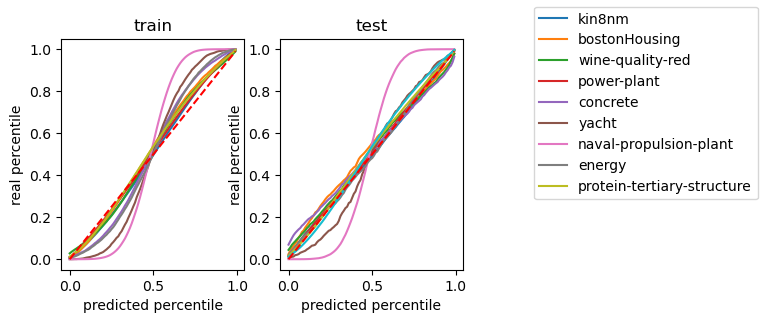

In [4]:
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
for n, calib in calibs_train:
    plt.plot(np.arange(100)/100, calib, label=n)
plt.plot(np.arange(100)/100, np.arange(100)/100, 'r--')
plt.title("train")
plt.ylabel('real percentile')
plt.xlabel('predicted percentile')
plt.subplot(1,3,3)
plt.figlegend()
plt.axis('off')
plt.subplot(1,3,2)
lines = [(plt.plot(np.arange(100)/100, calib, label=n), n) for (n,calib) in calibs_test]
plt.plot(np.arange(100)/100, calib)
plt.plot(np.arange(100)/100, np.arange(100)/100, 'r--')
plt.title("test")
plt.ylabel('real percentile')
plt.xlabel('predicted percentile')
plt.show()

In [16]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

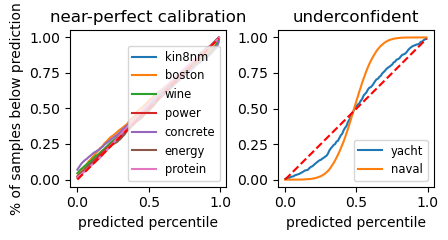

In [21]:
plt.figure(figsize=(4.5,2.5))
plt.subplot(1,2,1)


for n, calib in calibs_test:
    if n not in ['naval-propulsion-plant', 'yacht']:
        plt.plot(np.arange(100)/100, calib, label=datasets_order[n])
plt.title("near-perfect calibration")

plt.plot(np.arange(100)/100, np.arange(100)/100, 'r--')
plt.ylabel('% of samples below prediction')
plt.xlabel('predicted percentile')
plt.legend(loc="lower right", prop=fontP, bbox_to_anchor=(1.0, 0))

plt.subplot(1,2,2)

for n, calib in calibs_test:
    if n in ['naval-propulsion-plant', 'yacht']:
        plt.plot(np.arange(100)/100, calib, label=datasets_order[n])
plt.title("underconfident")

plt.plot(np.arange(100)/100, np.arange(100)/100, 'r--')

plt.xlabel('predicted percentile')
plt.legend(loc="lower right", prop=fontP, bbox_to_anchor=(1.0, 0))

plt.tight_layout()
plt.savefig('plots/crps_calibration.pdf', bbox_inches='tight')
plt.show()

In [7]:
print("\\begin{figure}\n\\centering")
for d, dn in datasets_order.items():
    print("""\\begin{subfigure}[t]{0.49\\linewidth}
        \centering
        \includegraphics[width=\\linewidth]{fig/calibration_%s.pdf}
        \caption{%s}
        \label{fig:apx_calib_%s}
      \\end{subfigure}"""%(d, dn, dn))
print("\\caption{Calibration for the $\\textrm{WCRPS}_\\textrm{e}$ model on all datasets separately for train and test sets}\\label{fig:calibration_all}\n\\end{figure}")

\begin{figure}
\centering
\begin{subfigure}[t]{0.49\linewidth}
        \centering
        \includegraphics[width=\linewidth]{fig/calibration_bostonHousing.pdf}
        \caption{boston}
        \label{fig:apx_calib_boston}
      \end{subfigure}
\begin{subfigure}[t]{0.49\linewidth}
        \centering
        \includegraphics[width=\linewidth]{fig/calibration_concrete.pdf}
        \caption{concrete}
        \label{fig:apx_calib_concrete}
      \end{subfigure}
\begin{subfigure}[t]{0.49\linewidth}
        \centering
        \includegraphics[width=\linewidth]{fig/calibration_energy.pdf}
        \caption{energy}
        \label{fig:apx_calib_energy}
      \end{subfigure}
\begin{subfigure}[t]{0.49\linewidth}
        \centering
        \includegraphics[width=\linewidth]{fig/calibration_kin8nm.pdf}
        \caption{kin8nm}
        \label{fig:apx_calib_kin8nm}
      \end{subfigure}
\begin{subfigure}[t]{0.49\linewidth}
        \centering
        \includegraphics[width=\linewidth]{fig/calibration_na